### Preprocessing
#### How to filters the data : 
- decide a locality to study
- filters habitants of this locality
- [1st method] keep all facilities where an individual of the locality went once
- [2nd method] get the max coordinates over the whole filter population (maybe add a term to each coordonates to not exclude these people to the limits of the facilities)
- exclude facilities outside this area
- then I have the population and the localities of this locality

#### How to keep only relevant schedules : 
- exclude the whole schedule where at least one time is not in above 23:59:59 (more complex : change this schedule to be at home at midnight or start at home) 
- exclude the whole schedule where a facility is not in the list of facilities (devient inutile avec la 1ere methode : j'aurais tous les schedules des habitants et j'inclus automatiquement leurs facilities)

Work only on people (represanted by their id) where I have a whole correct schedules for them.

Tout faire sous forme de fonctions comme ca je peux changer de lieux d'etude si j'ai envie

### Formating
Enfin formater les donnees pour les utiliser dans le script C (?)

In [52]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime, timedelta

### Download files and print them

In [2]:
# Specify the file paths
activity_file = 'vaud_activities.csv.gz'
population_file = 'vaud_population.csv.gz'
trip_file = 'vaud_trips.csv.gz'

# Read the gzipped CSV files
def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

# Read the dataframes
activity_df = read_gzipped_csv(activity_file)
population_df = read_gzipped_csv(population_file)
trip_df = read_gzipped_csv(trip_file)

In [4]:
print("Activity Data:")
print(activity_df.info())
print(activity_df.head(2))

Activity Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455006 entries, 0 to 4455005
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   id          int64  
 2   type        object 
 3   facility    object 
 4   link        object 
 5   x           float64
 6   y           float64
 7   start_time  object 
 8   end_time    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.9+ MB
None
   Unnamed: 0       id  type    facility    link          x          y  \
0      423464  1069770  home  home480932  399007  2569239.0  1190194.0   
1      423465  1069770  shop      168569  244909  2571696.0  1189601.0   

  start_time  end_time  
0        NaN  09:23:32  
1   09:25:32  09:33:32  


In [5]:
print("Population Data:")
print(population_df.info())
print(population_df.head(2))

Population Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825564 entries, 0 to 825563
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                825564 non-null  int64  
 1   age               825564 non-null  int64  
 2   bikeAvailability  825564 non-null  object 
 3   carAvail          825564 non-null  object 
 4   employed          825564 non-null  bool   
 5   hasLicense        825564 non-null  object 
 6   home_x            825564 non-null  float64
 7   home_y            825564 non-null  float64
 8   householdIncome   0 non-null       float64
 9   isCarPassenger    825564 non-null  bool   
 10  municipalityType  0 non-null       float64
 11  ptHasGA           825564 non-null  bool   
 12  ptHasHalbtax      825564 non-null  bool   
 13  ptHasStrecke      825564 non-null  bool   
 14  ptHasVerbund      825564 non-null  bool   
 15  sex               825564 non-null  object 
 16  spR

In [6]:
print("Trip Data:")
print(trip_df.info())
print(trip_df.head(2))

Trip Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629442 entries, 0 to 3629441
Data columns (total 12 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   id                int64 
 2   mode              object
 3   dep_time          object
 4   trav_time         object
 5   start_link        object
 6   end_link          object
 7   transitRouteId    object
 8   boardingTime      object
 9   transitLineId     object
 10  accessFacilityId  object
 11  egressFacilityId  object
dtypes: int64(2), object(10)
memory usage: 332.3+ MB
None
   Unnamed: 0       id  mode  dep_time trav_time start_link end_link  \
0      345939  1069770  walk  09:23:32  00:45:38     399007   244909   
1      345940  1069770  walk  10:09:10  00:45:38     244909   399007   

  transitRouteId boardingTime transitLineId accessFacilityId egressFacilityId  
0            NaN          NaN           NaN              NaN              NaN  
1            NaN     

### Analyses the files

In [9]:
# print(activity_df.groupby('type')['facility'].count())
print(activity_df.groupby('type')['facility'].nunique())

type
education           1039
home              358538
leisure            15510
other              36348
pt interaction         0
shop                8162
work               54328
Name: facility, dtype: int64


In [13]:
# WARNING : Doesn't exclude duplicates !

# plt.figure(figsize=(7,4))
# sns.histplot(activity_df['type'])
# plt.title('Distribution of activities')
# plt.show()

In [14]:
# a revoir pour la methode 1
def count_facilities_in_local_old(activity_df, local, population_df): 

    local_df = population_df[population_df['local'] == local]
    min_x, max_x = local_df['home_x'].min(), local_df['home_x'].max()
    min_y, max_y = local_df['home_y'].min(), local_df['home_y'].max()
    filtered_df = activity_df[(activity_df['x'] >= min_x) & (activity_df['x'] <= max_x) &
                              (activity_df['y'] >= min_y) & (activity_df['y'] <= max_y)]
    count_df = filtered_df.groupby('type')['facility'].nunique().reset_index()
    count_df.columns = ['Facility Type', 'Count']
    
    return count_df

def count_facilities_in_local(activity_df, local, population_df): 

    local_df = population_df[population_df['local'] == local]
    local_ids = local_df['id'].unique()
    
    filtered_df = activity_df[activity_df['id'].isin(local_ids)]
    count_df = filtered_df.groupby('type')['facility'].nunique().reset_index()
    count_df.columns = ['Facility Type', 'Count']
    
    return count_df


In [35]:
localities = population_df.groupby(['local']).count()['id'].sort_values(ascending=False).head(3).index
for local in localities:
    count_df = count_facilities_in_local(activity_df, local, population_df)
    print(f"\nHere's the count of facilities by types in {local} :")
    print(count_df)
# on remarque qu'a chaque fois le nb de home est 2x superieur au nb d'habitants
# pt interaction = public transport interaction ?


Here's the count of facilities by types in Lausanne :
    Facility Type  Count
0       education    215
1            home  94152
2         leisure   1454
3           other   4975
4  pt interaction      0
5            shop    974
6            work   9319

Here's the count of facilities by types in Cheseaux-Noréaz :
    Facility Type  Count
0       education     32
1            home  15089
2         leisure    200
3           other    918
4  pt interaction      0
5            shop    195
6            work   1537

Here's the count of facilities by types in Renens VD :
    Facility Type  Count
0       education     19
1            home  14420
2         leisure    140
3           other    669
4  pt interaction      0
5            shop    105
6            work   1011


##### 2) Population of Vaud

In [21]:
# WARNING : Doesn't exclude duplicates !

# plt.figure(figsize=(10,5)) 
# sns.histplot(population_df['local'])
# plt.xticks(rotation=45, ha='right', fontsize=5)  
# plt.title('Distribution of Localities in Vaud Canton')
# plt.tight_layout()  
# plt.show()


In [33]:
print("Population in local : \n")
print(population_df.groupby(['local']).nunique()['id'].sort_values(ascending=False).head(5))
print("\Population in municipality :")
population_df.groupby(['municipality']).nunique()['id'].sort_values(ascending=False).head(5)
# 2e resultat est bizarre
# sinon c'est tjrs un peu over estimating mais coherent

Population in local : 

local
Lausanne           139392
Cheseaux-Noréaz     32372
Renens VD           24196
Nyon                21597
Vevey               21217
Name: id, dtype: int64
\Population in municipality :


municipality
Lausanne           142041
Cheseaux-Noréaz     32372
Montreux            26761
Renens (VD)         24196
Nyon                21597
Name: id, dtype: int64

In [37]:
# Viewing # of unique values for each column
print("Unique Postcodes: ", population_df['postcode'].nunique())
print("Unique Locals: ", population_df['local'].nunique())
print("Unique Municipalities: ", population_df['municipality'].nunique())
print(f"Population age is {population_df['age'].mean().round()}")

# Quelle difference ? 
# print(population_df[['postcode', 'local', 'municipality']].drop_duplicates().head())


Unique Postcodes:  321
Unique Locals:  314
Unique Municipalities:  251
Population age is 42.0


In [38]:
# Create palette of colors for the facilities type

palette = sns.color_palette("husl", n_colors=len(set(activity_df['type'])))
color_palette = dict(zip(set(activity_df['type']), palette))
color_palette['transport'] = 'grey'

In [25]:
def plot_schedule(activity_df, individual_id):
    # Filter the DataFrame for the specific id
    # ASSUMPTION : les activites sont deja chronologiques pour chaque individual id
    # ASSUMPTION : chaque individu n'a qu'une journee dans le dataframe
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    
    segments = []
    colors = []
    fig, ax = plt.subplots(figsize=(10, 1))
    
    start_of_day = datetime.strptime('00:00:00', '%H:%M:%S')
    end_of_day = datetime.strptime('23:59:59', '%H:%M:%S')
    prev_end = start_of_day
    
    for _, facility in individual_schedule.iterrows():
        start_time = datetime.strptime(facility['start_time'], '%H:%M:%S') if pd.notna(facility['start_time']) else start_of_day
        end_time = datetime.strptime(facility['end_time'], '%H:%M:%S') if pd.notna(facility['end_time']) else end_of_day
        
        if prev_end < start_time:
            segments.append([(prev_end - start_of_day).total_seconds() / 3600, (start_time - prev_end).total_seconds() / 3600])
            colors.append(color_palette['transport'])
            ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
            
        segments.append([(start_time - start_of_day).total_seconds() / 3600, (end_time - start_time).total_seconds() / 3600])
        colors.append(color_palette[facility['type']])
        ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
        
        prev_end = end_time


    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlim(0, 24)
    ax.set_yticks([])
    ax.set_xticks(range(25))
    ax.set_xlabel('Time (hours)')
    plt.show()

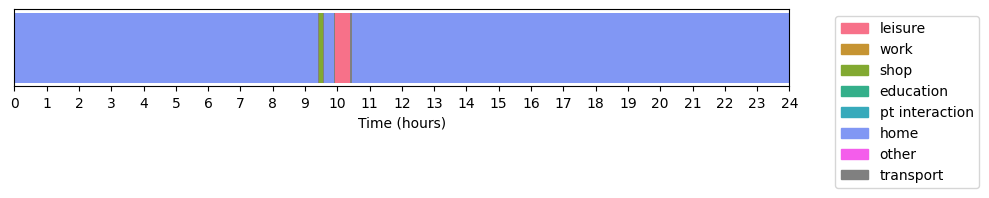

In [32]:
# individual_id = 1071953
individual_id = 1069770 
plot_schedule(activity_df, individual_id)

In [65]:
def valid_time(time_str):
    if not isinstance(time_str, str):
        return False
    try:
        datetime.strptime(time_str, '%H:%M:%S')
        return True
    except ValueError:
        return False


In [66]:
def plot_start_time_distribution(activity_df, activity_type, local=None):

    # TO DO : function that get the activity_df for a locality 
    # if local is not None:
    #     activity_local_df = activity_df[activity_df["local"] == local]
    # else: 
    #     activity_local_df = activity_df

    activity_type_df = activity_df[activity_df['type'] == activity_type] # activity_local_df
    activity_type_df['start_time'].dropna(inplace=True)
    activity_type_df = activity_type_df[activity_type_df['start_time'].apply(valid_time)] # should be done before the function call !
    start_times = activity_type_df['start_time'].dropna()
    hours = start_times.apply(lambda x: datetime.strptime(x, '%H:%M:%S').hour + datetime.strptime(x, '%H:%M:%S').minute / 60)
    
    plt.figure(figsize=(4, 3))
    plt.hist(hours, bins=24, range=(0,24), edgecolor='black', alpha=0.7, color='dodgerblue', density=True)
    plt.title(f'Start Time Distribution of {activity_type} Activity')
    plt.xlabel('Time (hours)')
    plt.ylabel('Density')
    plt.xticks(range(25))
    plt.tight_layout()
    plt.show()

C:\Users\helli\AppData\Local\Temp\ipykernel_18300\2806071363.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_type_df['start_time'].dropna(inplace=True)


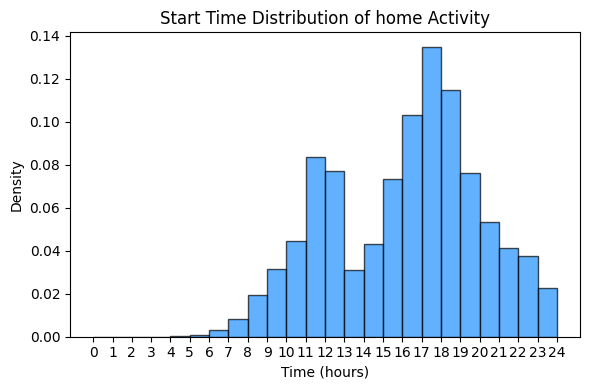

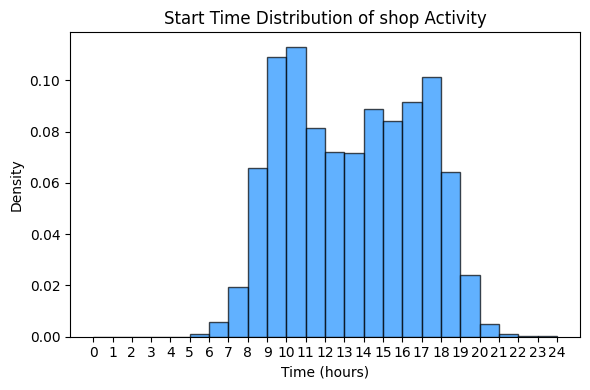

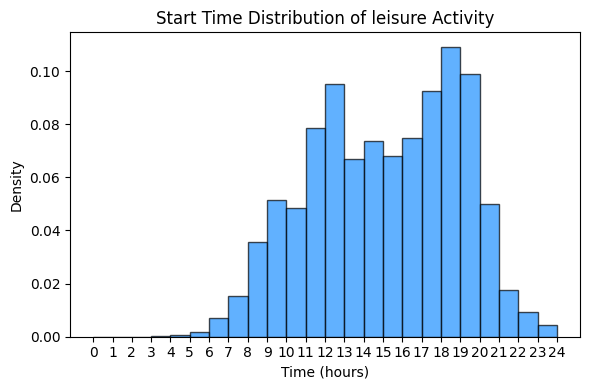

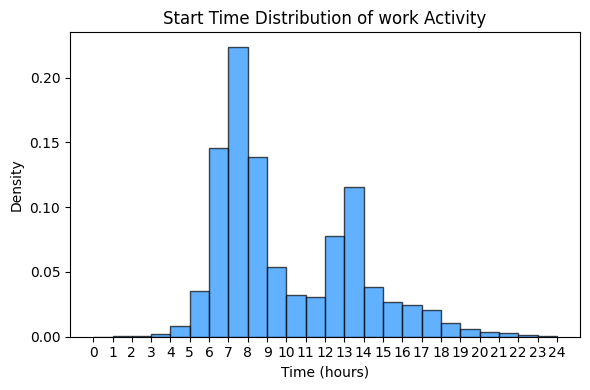

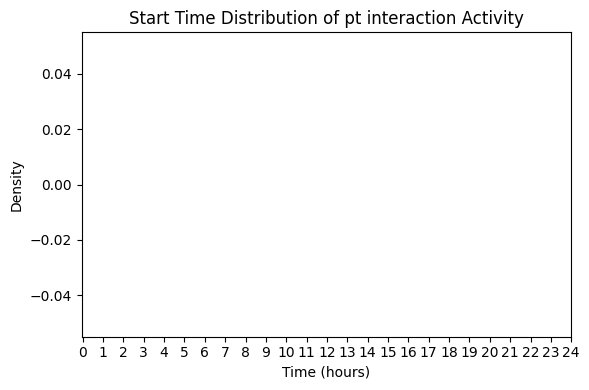

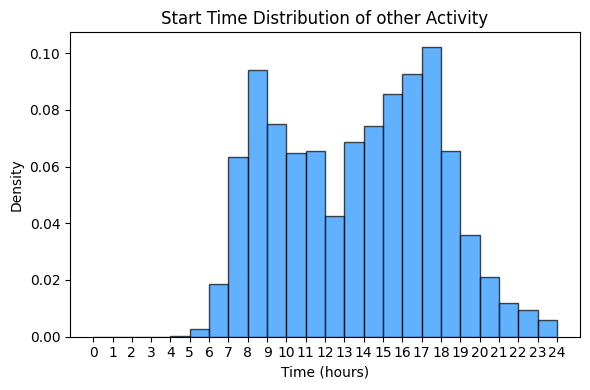

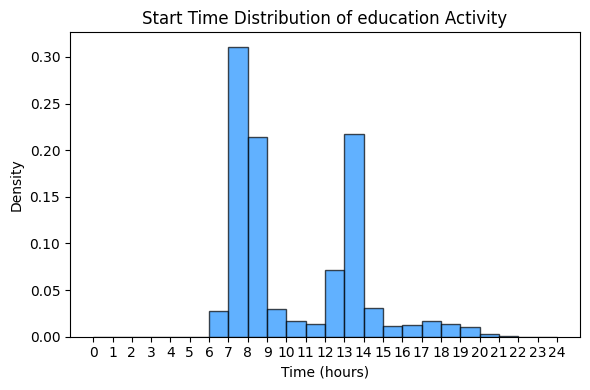

In [68]:
activities_type = pd.unique(activity_df["type"])
for activity_type in activities_type:
    # print(activity_type)
    plot_start_time_distribution(activity_df, activity_type)